In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')

import collections

%autoreload
import dataset

%autoreload
import transformer

In [55]:
BATCH_SIZE = 32

MAXLEN = 40

LETTERS_SIZE = len(dataset.letters_table)
NIQQUD_SIZE = len(dataset.niqqud_table)
DAGESH_SIZE = len(dataset.dagesh_table)
SIN_SIZE = len(dataset.sin_table)

d_model = 54

model = transformer.Transformer(
    num_layers=1,
    d_model=d_model,
    num_heads=6,
    dff=1024,
    input_vocab_size=LETTERS_SIZE,
    target_vocab_size=NIQQUD_SIZE, 
    maximum_position_encoding_input=MAXLEN, 
    maximum_position_encoding_target=MAXLEN,
    rate=0.0
)

learning_rate = transformer.CustomSchedule(d_model, warmup_steps=3000)
model.compile(
    optimizer=tf.keras.optimizers.Adam(8e-4),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
# pseudo "build" step, to allow printing a summary:
model.pseudo_build(MAXLEN, MAXLEN)
model.summary()
model.save_weights('./checkpoints/uninit')

Model: "transformer_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_18 (Encoder)         multiple                  126142    
_________________________________________________________________
decoder_18 (Decoder)         multiple                  136618    
_________________________________________________________________
dense_322 (Dense)            multiple                  880       
Total params: 263,640
Trainable params: 263,640
Non-trainable params: 0
_________________________________________________________________


In [8]:
def load_data(source, validation=0.1):
    filenames = [os.path.join('texts', f) for f in source]
    train, valid = dataset.load_data(filenames, validation, maxlen=MAXLEN)
    return train, valid


def fit(data, epochs=1):
    train, valid = data
    total = len(data[0])//BATCH_SIZE
    history = collections.defaultdict(list)
    for epoch in range(epochs):
        for i in range(total):
            s = slice(i*BATCH_SIZE, (i+1)*BATCH_SIZE)
            res = model.train_step(train.normalized[s], train.niqqud[s])
            out = ' - '.join(f"{k}: {v:.4f}" for k, v in res.items() if k != "predictions")
            print(f"{i:4d}/{total:4d} - {out}", end='      \r')
        print()
        for k, v in res.items():
            history[k].append(res[k].numpy())
    return history

In [25]:
data_other = load_data(['biblical', 'garbage'])

In [26]:
data_mix = load_data(['poetry', 'rabanit', 'pre_modern'])

In [6]:
data_modern = load_data(validation=0.1, source=['modern'])

In [35]:
model.load_weights('./checkpoints/uninit')
history = fit(data_other, epochs=10)
model.save_weights('./checkpoints/other')

2323/2324 - loss: 4.9746 - accuracy: 0.0715                                                                                                                                     
2323/2324 - loss: 3.8794 - accuracy: 0.2091                                                                              
2323/2324 - loss: 2.9868 - accuracy: 0.3707                                                                                                                                                
2323/2324 - loss: 2.4553 - accuracy: 0.4587                                                                  
2323/2324 - loss: 2.1267 - accuracy: 0.5125                                                            
2323/2324 - loss: 1.9012 - accuracy: 0.5489                                                                              
2323/2324 - loss: 1.7400 - accuracy: 0.5745                                          
2323/2324 - loss: 1.6189 - accuracy: 0.5936                                                

In [51]:
model.load_weights('./checkpoints/other')
history = fit(data_mix, epochs=1) # (102, 2048, 6) warmup=270 : 974,746 - 0.8323  (7 - same)
model.save_weights('./checkpoints/mix')

7247/7248 - loss: 0.7430 - accuracy: 0.7379                                                                                                                                                                                                


In [56]:
model.load_weights('./checkpoints/mix')
history = fit(data_modern, epochs=15)
# print(true_accuracy(data_modern)
model.save_weights('./checkpoints/modern')

 868/ 869 - loss: 0.7812 - accuracy: 0.7187                              
 868/ 869 - loss: 0.7807 - accuracy: 0.7187                                    
 868/ 869 - loss: 0.7805 - accuracy: 0.7187                                                                                          


KeyboardInterrupt: 

In [ ]:
model.load_weights('./checkpoints/modern')

def print_predictions(data, s):
    batch = data.normalized[s]
    prediction = model.predict(batch)
    [actual_niqqud, actual_dagesh, actual_sin] = [dataset.from_categorical(prediction[0]), dataset.from_categorical(prediction[1]), dataset.from_categorical(prediction[2])]
    [expected_niqqud, expected_dagesh, expected_sin] = [data.niqqud[s], data.dagesh[s], data.sin[s]]
    actual = dataset.merge(data.text[s], ts=batch, ns=actual_niqqud, ds=actual_dagesh, ss=actual_sin)
    expected = dataset.merge(data.text[s], ts=batch, ns=expected_niqqud, ds=expected_dagesh, ss=expected_sin)
    total = []
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        last = expected_niqqud[i].tolist().index(0)
        res = expected_niqqud[i][:last] == actual_niqqud[i][:last]
        total.extend(res)
        print(f'{np.mean(res):.2f} ({last - sum(res)} out of {last})')
        print()
    print(round(np.mean(total), 3))

print_predictions(data_modern[1], slice(0, None))

ValueError: x and y can be no greater than 2-D, but have shapes (3,) and (3, 32, 40, 16)

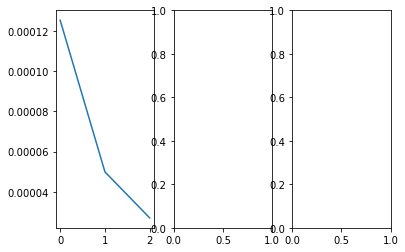

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=len(history))

for i, v in enumerate(history.values()):
    ax[i].plot(v)

plt.tight_layout()

In [ ]:
model.load_weights('./checkpoints/modern')
def evaluate(inp_sentence):
    encoder_input = tf.expand_dims(inp_sentence, 0)
    print(encoder_input)
    output = [0] * len(inp_sentence)
    print(output)
    size = inp_sentence.shape[0]
    last = inp_sentence.tolist().index(0)
    for i in range(last):
        padding_mask = transformer.create_padding_mask(encoder_input)
        look_ahead_mask = transformer.create_look_ahead_mask(size)
        combined_mask = tf.maximum(padding_mask, look_ahead_mask)
        
        output_tensor = tf.constant([output], dtype=tf.int32)
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(encoder_input, output_tensor, False, padding_mask, combined_mask, padding_mask)

        # select the last character from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # concatentate the predicted_id to the output which is given to the decoder as its input.
        output[i] = predicted_id.numpy()[0][-1]
        print(combined_mask[0, 0, i, :].numpy())
        print(output)
        print()

evaluate(data_modern[0].normalized[0])

In [65]:

def merge(normalized, prediction):
    sentence = []
    for c, n in zip(normalized, prediction):
        if c == dataset.letters_table.PAD_TOKEN:
            break
        sentence.append(dataset.letters_table.indices_char[c])
        sentence.append(dataset.niqqud_table.indices_char[n])
    return ''.join(sentence)

d = data_other
text = d[0].normalized[0]
prediction = np.argmax(history['predictions'], axis=-1)[0]
actual = d[0].niqqud[:BATCH_SIZE]
print(text)
print(prediction[0])
print(actual[0])
print(np.mean(prediction == actual))
print(merge(text, prediction[0]))
print(merge(text, actual[0]))

[18 33 26  5 33 40 22 20 17  5 42 42  5 31 17 22 43  5 24 31 42 26 30  5
 22 42 33 26 30  5 22 31 18 33 26  5  0  0  0  0]
[ 6  4 11  1  1 11  6 10  1  1 10  6  1  1  1 11  1  1  6  1  1 11  7 10
  1  1  1  7 10 11  1  1  1 11  1  1  1 11 11 11]
[ 2  7  1  1  2  1 11 10  1  1  7  1  1  7  1 11  1  1  4  6  6  1  1  1
 14  2 10  6  1  1 14  6  2  7  1  1  0  0  0  0]
0.253125
בִנֲיֹ נקֹוִדָא שָשִ מאוֹת חִמשיֹםֵ ָושניֵםָ ֹומבנֹי ֹֹֹ
בְנֵי נְקוֹדָא שֵש מֵאוֹת חֲמִשִים וּשְנָיִם וּמִבְנֵי 
